## Spiral septagon fractal

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [ ]:
try:
    from numba import njit, prange
    NUMBA = True
except Exception:
    NUMBA = False

In [18]:
if NUMBA:
    @njit(parallel=True, fastmath=True, cache=True)
    def _render_field(width, height, cx, cy, scale, cs, sn,
                      phi, max_iter, bailout, ss,
                      use_nic, deg_d, eps):
        """
        Return (field, pole) where:
          - field[j,i] is the averaged iteration value (smooth if use_nic)
          - pole[j,i] is the fraction of supersamples that hit |z| < eps (holes)
        """
        out  = np.zeros((height, width), np.float64)
        pole = np.zeros((height, width), np.float64)
        ar = height / width
        eps2 = eps * eps
        bailout2 = bailout * bailout

        for j in prange(height):
            for i in range(width):
                acc = 0.0
                pole_hits = 0
                for sy in range(ss):
                    for sx in range(ss):
                        u = (i + (sx + 0.5) / ss) / width  - 0.5
                        v = (j + (sy + 0.5) / ss) / height - 0.5

                        # rotate + scale + translate to world coords
                        x = scale * ( u*cs - (v*ar)*sn ) + cx
                        y = scale * ( u*sn + (v*ar)*cs ) + cy
                        z = x + 1j*y

                        escaped = False
                        hit_pole = False
                        mod2 = 0.0
                        n = 0

                        for n in range(max_iter):
                            # pole guard (avoid division by ~0)
                            mod2 = z.real*z.real + z.imag*z.imag
                            if mod2 < eps2:
                                hit_pole = True
                                break

                            z2 = z * z
                            z4 = z2 * z2
                            z6 = z4 * z2
                            z  = (z6 * z + phi) / z   # iterate

                            mod2 = z.real*z.real + z.imag*z.imag
                            if mod2 > bailout2:
                                escaped = True
                                break

                        if hit_pole:
                            pole_hits += 1
                            val = 0.0
                        elif escaped:
                            if use_nic:
                                mod = math.sqrt(mod2)
                                val = (n + 1) - math.log(math.log(mod) / math.log(bailout)) / math.log(deg_d)
                            else:
                                val = n
                        else:
                            val = n  

                        acc += val

                out[j, i]  = acc / (ss * ss)
                pole[j, i] = pole_hits / (ss * ss)

        return out, pole

else:
    def _render_field(width, height, cx, cy, scale, cs, sn,
                      phi, max_iter, bailout, ss,
                      use_nic, deg_d, eps):
        out  = np.zeros((height, width), np.float64)
        pole = np.zeros((height, width), np.float64)
        ar = height / width
        eps2 = eps * eps
        bailout2 = bailout * bailout

        for j in range(height):
            for i in range(width):
                acc = 0.0
                pole_hits = 0
                for sy in range(ss):
                    for sx in range(ss):
                        u = (i + (sx + 0.5) / ss) / width  - 0.5
                        v = (j + (sy + 0.5) / ss) / height - 0.5

                        x = scale * ( u*cs - (v*ar)*sn ) + cx
                        y = scale * ( u*sn + (v*ar)*cs ) + cy
                        z = x + 1j*y

                        escaped = False
                        hit_pole = False
                        mod2 = 0.0
                        n = 0

                        for n in range(max_iter):
                            mod2 = z.real*z.real + z.imag*z.imag
                            if mod2 < eps2:
                                hit_pole = True
                                break

                            z2 = z * z
                            z4 = z2 * z2
                            z6 = z4 * z2
                            z  = (z6 * z + phi) / z

                            mod2 = z.real*z.real + z.imag*z.imag
                            if mod2 > bailout2:
                                escaped = True
                                break

                        if hit_pole:
                            pole_hits += 1
                            val = 0.0
                        elif escaped:
                            if use_nic:
                                mod = math.sqrt(mod2)
                                val = (n + 1) - math.log(math.log(mod) / math.log(bailout)) / math.log(deg_d)
                            else:
                                val = n
                        else:
                            val = n

                        acc += val

                out[j, i]  = acc / (ss * ss)
                pole[j, i] = pole_hits / (ss * ss)

        return out, pole




In [ ]:

def spiral_septagon(width=1600, height=1600,
                    center=(0.0, 0.0), scale=2.0, theta=0.0,
                    phi=-0.7/5.0, max_iter=160, bailout=1e6,
                    ss=1, smooth=True, cmap="Greys_r",
                    exposure=(1.0, 99.6), gamma=0.85,
                    out=None):
    """
    width, height : image size
    center        : (x,y) center in world coords
    scale         : view width in world units
    theta         : rotation (radians)
    phi           : parameter in (z^7 + phi)/z (default -0.7/5 )
    max_iter      : iteration cap
    bailout       : escape radius
    ss            : supersampling factor (1,2,3...)
    smooth        : use normalized iteration count coloring
    cmap          : matplotlib colormap
    exposure      : (low, high) percentiles for contrast stretch
    gamma         : tone curve (lower -> brighter midtones)
    out           : optional path to save margin‑free PNG
    """
    cx, cy = float(center[0]), float(center[1])
    cs, sn = math.cos(theta), math.sin(theta)
    deg_d  = 6.0  
    eps    = 1e-12

    field, pole = _render_field(width, height, cx, cy, scale, cs, sn,
                                float(phi), int(max_iter), float(bailout), int(ss),
                                bool(smooth), deg_d, eps)

    data = field.astype(np.float64)
    nz = data[np.isfinite(data)]
    lo = np.percentile(nz, exposure[0]) if nz.size else 0.0
    hi = np.percentile(nz, exposure[1]) if nz.size else 1.0
    if hi <= lo: hi = lo + 1e-9
    D = (data - lo) / (hi - lo)
    D = np.clip(D, 0, 1)
    D = D**(1.0 - gamma)

    D = (1.0 - pole) * D + pole * 1.0

    plt.figure(figsize=(8, 8), dpi=200)
    plt.imshow(D, origin="lower", cmap=cmap, interpolation="bilinear")
    plt.axis("off")
    plt.show()

    if out:
        plt.imsave(out, D, origin="lower", cmap=cmap)
        print("Saved:", out)

    return D



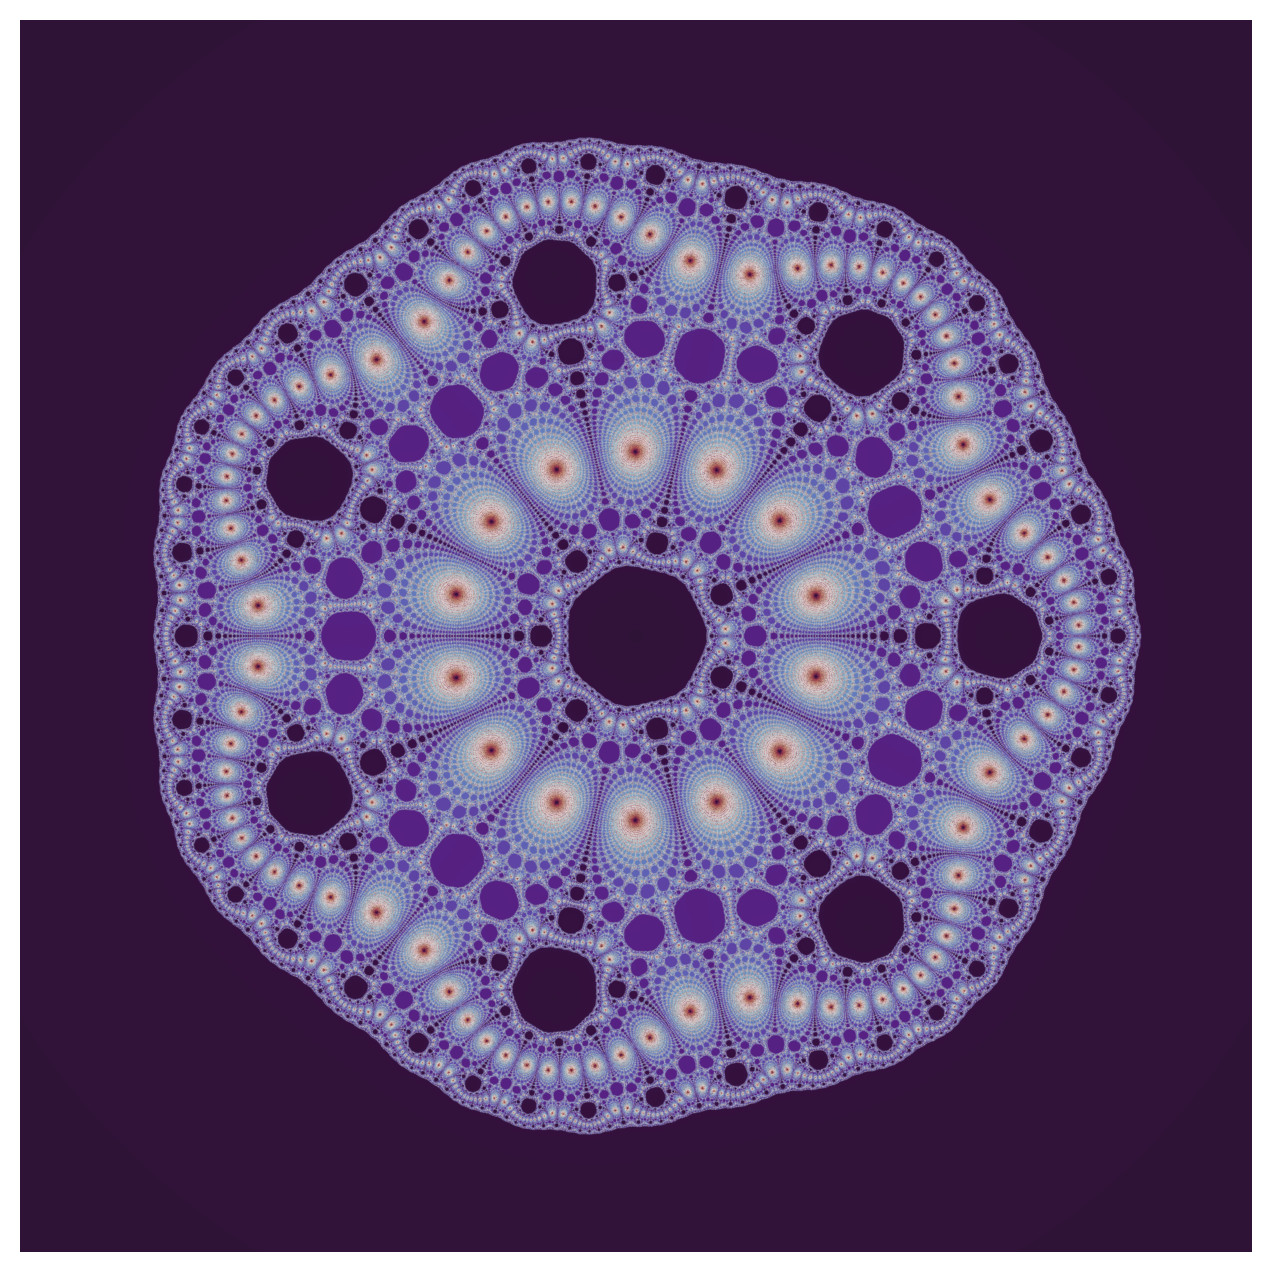

Saved: septagon_fractal.png


In [57]:
_ = spiral_septagon(
    width=4000, height=4000,
    center=(0.0, 0.0), scale=2.5, theta=0.0,
    phi=-0.7/5.0, max_iter=500_000_00, bailout=1e6,
    ss=1, smooth=False, cmap="twilight_shifted",
    exposure=(1.0, 99.6), gamma=0.35,
    out="septagon_fractal.png" 
)
